# Beam Search vs A-Star Search

## Introduction
Beam search and A-star are two important search algorithms. Both are used to find the shortest path between 2 points in a graph. Let's explain the differences between these 2 algorithms and compare their performance.

We'll start by defining the graph that we need to search. This is just a grid with some obstacles (1's) and some open lanes (0's). The goal is to find the shortest path between the start and end points.

In [1]:
# Define a larger grid with obstacles
grid = [
    [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
    [0, 1, 0, 1, 0, 1, 1, 0, 1, 0],
    [0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
    [0, 1, 1, 1, 1, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
    [0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
]

We'll define a `visualize_grid` function to help us visualize the grid.

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def visualize_grid(grid, start, goal, a_star_path=None, beam_search_path=None, 
                   beam_search_paths=None, beam_width=None, ax=None, path_color=None):
    rows, cols = len(grid), len(grid[0])
    
    grid_visual = np.zeros((rows, cols, 3))
    
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] == 1:
                grid_visual[r, c] = [0, 0, 0]  # Black for obstacles
            else:
                grid_visual[r, c] = [1, 1, 1]  # White for free spaces
    
    if a_star_path:
        for r, c in a_star_path:
            grid_visual[r, c] = [0, 0, 1]  # Blue for A* path
        a_star_steps = len(a_star_path) - 1
    else:
        a_star_steps = None
    
    if beam_search_path:
        path_color_rgb = mcolors.to_rgb(path_color) if path_color else [1, 0, 0]
        for r, c in beam_search_path:
            grid_visual[r, c] = path_color_rgb  # Use the provided color or default to red
        beam_search_steps = len(beam_search_path) - 1
    else:
        beam_search_steps = None
    
    if beam_search_paths:
        colors = plt.cm.rainbow(np.linspace(0, 1, len(beam_search_paths)))
        for path, color in zip(beam_search_paths, colors):
            for r, c in path:
                grid_visual[r, c] = color[:3]  # Use rainbow colors for multiple beam search paths
    
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(grid_visual)
    
    ax.text(start[1], start[0], 'Start', color='green', fontsize=8, ha='center', va='center', weight='bold')
    ax.text(5.5, 5, 'Tricky', color='purple', fontsize=8, ha='center', va='center', weight='bold')
    ax.text(goal[1], goal[0], 'End', color='orange', fontsize=8, ha='center', va='center', weight='bold')
    
    if beam_width is not None:
        title = f"Beam Width: {beam_width}"
    else:
        title = ""
    if beam_search_paths:
        title += f"\n{len(beam_search_paths)} paths"
    if a_star_steps is not None:
        title += f"\nA* Steps: {a_star_steps}"
    if beam_search_steps is not None:
        title += f"\nBeam Search Steps: {beam_search_steps}"
    
    ax.set_title(title)
    ax.grid(False)
    
    if ax is None:
        plt.show()

And then we'll visualize the grid.

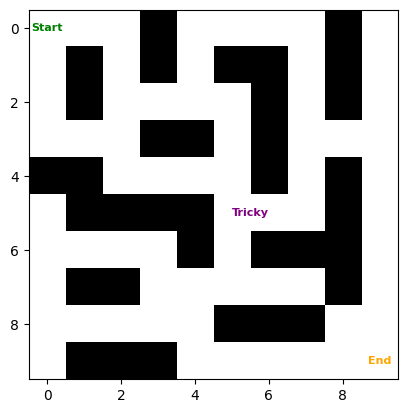

In [13]:
visualize_grid(grid, start=(0, 0), goal=(9, 9))

There's a bit of a tricky part in this grid. At the center, you need to go *backwards* (away from the end point) to reach the final point. This tests the ability of the algorithms to backtrack and find the shortest path.

## Algorithm: A* Search

We'll start by implementing the A* search algorithm. This algorithm is a combination of [Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) and a **heuristic function**. The heuristic function is used to estimate the distance between the current node and the end node. The algorithm then selects the node with the smallest cost to expand next.

The typical heuristic function used is the Manhattan distance (because we only allow up, down, left, and right movements). We'll use this heuristic function in our implementation.

The algorithm is typically implemented using a priority queue. We'll use the `heapq` library in Python to implement the priority queue.

The algorithm is as follows:
1. Initialize the start node with a cost of 0 and add it to the priority queue.
2. While the priority queue is not empty:
    1. Pop the node with the smallest cost from the priority queue.
    2. If the node is the end node, return the path.
    3. Otherwise, expand the node and add its neighbors to the priority queue.
3. If the priority queue is empty, return None.

In [4]:
import heapq

# A* search function
def a_star(start, goal):
    rows, cols = len(grid), len(grid[0])
    
    # Heuristic function (Manhattan distance)
    def heuristic(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])
    
    # Initialize the open set (priority queue)
    open_set = []
    heapq.heappush(open_set, (0, start))
    
    # Dictionaries to store the cost of getting to each node and the path
    came_from = {}
    g_score = {start: 0}
    
    while open_set:
        _, current = heapq.heappop(open_set)
        
        if current == goal:
            # Reconstruct the path
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]  # Reverse path to get from start to goal
        
        # Neighbors (up, down, left, right)
        neighbors = [(current[0] + dx, current[1] + dy) for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]]
        for neighbor in neighbors:
            x, y = neighbor
            if 0 <= x < rows and 0 <= y < cols and grid[x][y] == 0:
                tentative_g_score = g_score[current] + 1
                
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score, neighbor))
    
    return None  # No path found


Run the algorithm by executing the following code:

In [5]:
# Run the algorithm
start = (0, 0)
goal = (9, 9)

# Run A* Search
a_star_path = a_star(start, goal)

We see the algorithm is able to navigate the grid and find the shortest path. It gets to the end goal in 20 steps.

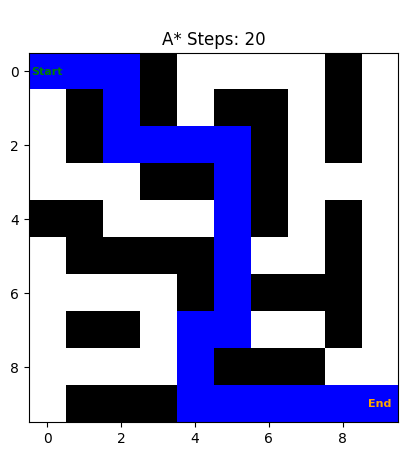

In [6]:
visualize_grid(grid, start=(0, 0), goal=(9, 9), a_star_path=a_star_path)

## Algorithm: Beam Search

Beam search is a simpler algorithm compared to A-star search. The algorithm has a parameter called `beam_width` which determines the number of nodes (or paths) kept open at each step, and the rest are pruned. Beam search is a breadth-first search algorithm that expands only a fixed number of top candidate nodes at each step, based on a scoring function (which could include a heuristic). 

It is not guaranteed to find the optimal path like A*, but it is often used in contexts where finding a reasonable solution quickly is more important than guaranteeing the best solution.

The algorithm is as follows:
1. Initialize the start node with a cost of 0 and add it to the priority queue.
2. While the priority queue is not empty:
    1. Pop the `beam_width` nodes with the smallest cost from the priority queue.
    2. If any of the nodes is the end node, return the path.
    3. Otherwise, expand the nodes and add their neighbors to the priority queue.
3. If the priority queue is empty, return None.


In [17]:
# Beam search function with heuristic
def beam_search(start, goal, beam_width=2):
    rows, cols = len(grid), len(grid[0])
    
    # Heuristic function (Manhattan distance)
    def heuristic(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])
    
    # Initialize the beam with the starting point (f_score, current position, path)
    beam = [(heuristic(start, goal), start, [start])]
    
    # List to store all paths explored in each iteration
    all_paths = [beam]  # Store initial state
    
    while beam:
        next_candidates = []
        for _, current, path in beam:
            if current == goal:
                return (path, all_paths)  # Return the successful path and all paths explored
            
            # Generate neighbors (up, down, left, right)
            neighbors = [(current[0] + dx, current[1] + dy) for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]]
            for neighbor in neighbors:
                x, y = neighbor
                if 0 <= x < rows and 0 <= y < cols and grid[x][y] == 0 and neighbor not in path:
                    new_path = path + [neighbor]
                    # f(n) = g(n) + h(n)
                    f_score = len(new_path) + heuristic(neighbor, goal)
                    next_candidates.append((f_score, neighbor, new_path))
        
        # Prune to keep only the top beam_width candidates
        beam = heapq.nsmallest(beam_width, next_candidates)
        
        # Add current state of the beam to all_paths for each iteration
        all_paths.append(beam)
    
    return (None, all_paths)  # If no path found, return None and all paths explored



In [18]:
def visualize_beam_search_final(grid, start, goal, beam_widths):
    fig, axes = plt.subplots(1, len(beam_widths), figsize=(5*len(beam_widths), 5))
    if len(beam_widths) == 1:
        axes = [axes]
    
    for i, beam_width in enumerate(beam_widths):
        final_path, _ = beam_search(start, goal, beam_width)
        visualize_grid(grid, start, goal, beam_search_path=final_path, beam_width=beam_width, ax=axes[i])
    
    plt.tight_layout()
    plt.show()

The `beam_width` parameter is a hyperparameter that needs to be tuned. A larger `beam_width` will explore more nodes and may find the shortest path, but it will also be slower. A smaller `beam_width` will explore fewer nodes and may not find the shortest path, but it will be faster.

When the `beam_width` is set to 1, the algorithm is equivalent to Dijkstra's algorithm. When the `beam_width` is set to the number of nodes in the graph, the algorithm is equivalent to breadth-first search. 

We'll look at the performance of the beam search algorithm with different values of `beam_width`. We'll start with a `beam_width` of 1 and increase it to 9.

We see that the algorithm is not able to find the shortest path with a `beam_width` of 1. It returns a path of 22 steps (+2 compared to A-star). 

However, as we increase the `beam_width`, the algorithm is able to find the shortest path. With a `beam_width` of 9, the algorithm is able to find the shortest path in 20 steps, which is the same as the A-star search algorithm.

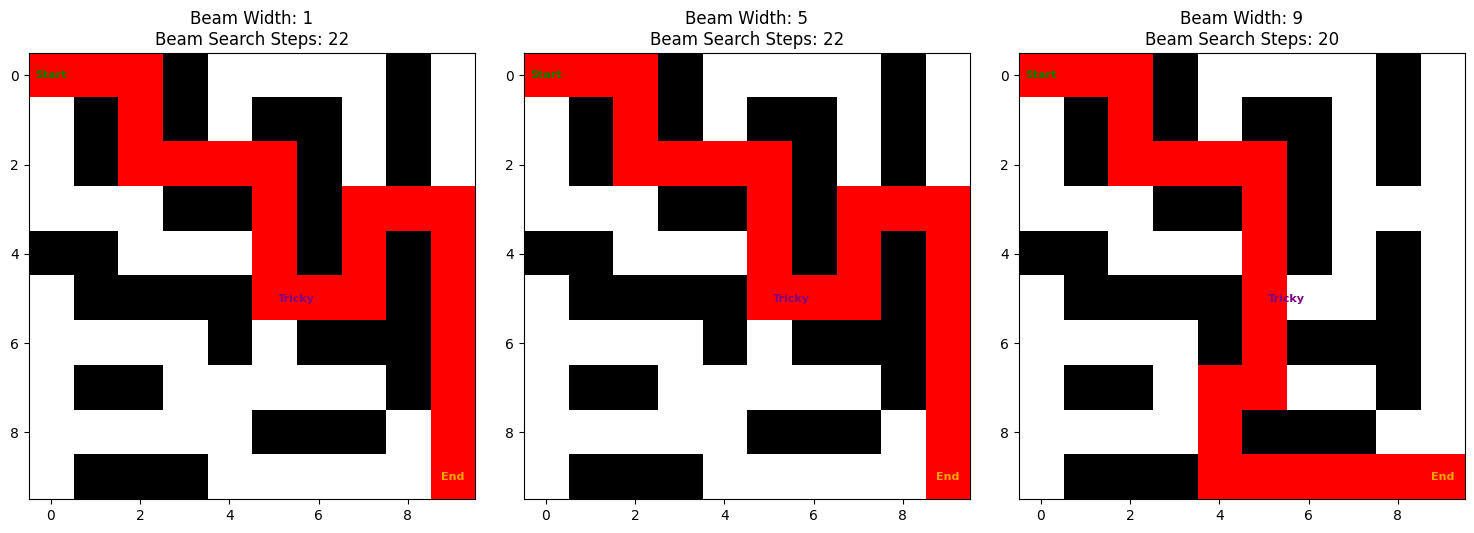

In [26]:
# To visualize only the final paths for different beam widths
visualize_beam_search_final(grid, start=(0, 0), goal=(9, 9), beam_widths=[1, 5, 9])

What is `beam_width` doing here? A smaller `beam_width` will explore fewer different paths. A larger `beam_width` will keep more promising options open. It may find the shortest path, but it will be slower.

Let's visualize all of the options that beam search is keeping open. When the `beam_width` is set to 9, we see that it's keeping 9 different paths open at each step. This is why it's able to find the shortest path.

In [20]:
def visualize_beam_search_all_paths(grid, start, goal, beam_width):
    final_path, all_paths = beam_search(start, goal, beam_width)
    
    # Get the paths from the last iteration
    last_iteration_paths = all_paths[-1]
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    
    # Generate distinct colors for each path
    colors = plt.cm.rainbow(np.linspace(0, 1, 9))
    colors = colors[::-1]  # Reverse the color order
    
    for i, (score, _, path) in enumerate(last_iteration_paths[:9]):  # Show up to 9 paths
        color = mcolors.rgb2hex(colors[i][:3])  # Convert RGB to hex color code
        visualize_grid(grid, start, goal, beam_search_path=path, beam_width=beam_width, ax=axes[i], path_color=color)
        path_length = len(path) - 1  # Subtract 1 because the start node is included
        score = score - 1  # Subtract 1 because the start node is included
        if path == final_path:
            axes[i].set_title(f"Path {i+1} (Final Path)\nScore: {score:.2f}", color=color)
        else:
            axes[i].set_title(f"Path {i+1}\nScore: {score:.2f}", color=color)
    
    # If there are fewer than 9 paths, turn off the unused subplots
    for i in range(len(last_iteration_paths), 9):
        axes[i].axis('off')
    
    plt.suptitle(f"Beam Search Paths (Beam Width: {beam_width})", fontsize=16)
    plt.tight_layout()
    plt.show()

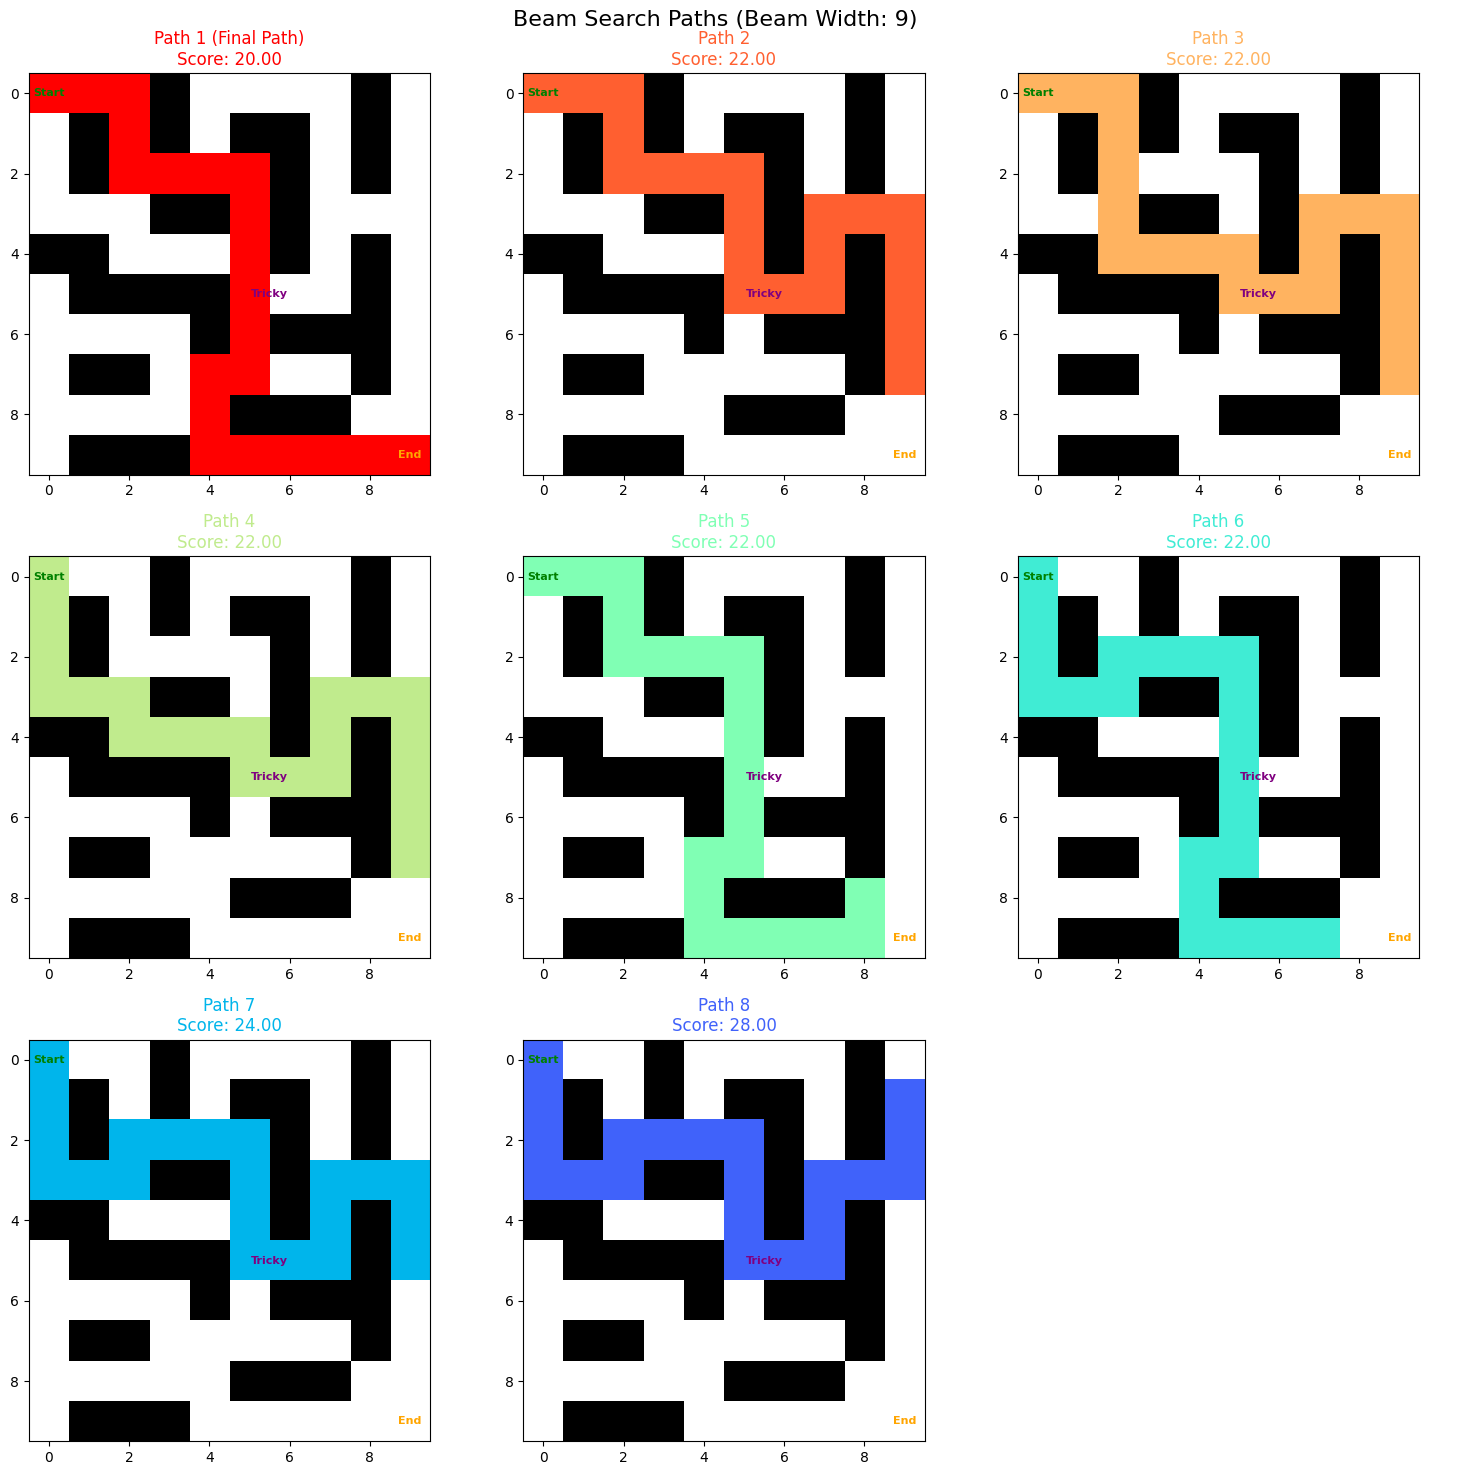

In [21]:
# To visualize all paths for a specific beam width in a 3x3 grid
visualize_beam_search_all_paths(grid, start=(0, 0), goal=(9, 9), beam_width=9)